In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import os
import sys
import re
from time import process_time
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from apachelogs import LogParser

## CLF Processing for Analytics
Local processing of combined log format (CLF) into forms that are more usable for data analysis.

- `apachelogs` package used to parse logs. 

This isn't the most efficient code, but list comprehension usage speeds things up so a fairly large amount of logs can be processed relatively quickly (for imaging node, this notebook code can process roughly 2.4M lines of http logs or about 30 days worth in just under 3 minutes).

In [65]:
data_dir = Path('/Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/')
column_names = ['ip', 'identd', 'userid', 'date', 'time', 'timezone', 'request', 'status', 'size', 'referer', 'user_agent']
log_files = [data_dir / f for f in os.listdir(data_dir)].sort()
df_logs = pd.DataFrame(columns=column_names)
parser = LogParser("%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\"")

In [68]:
data

In [13]:
df_http_logs = pd.DataFrame(columns=column_names)
log_files = sorted([data_dir / f for f in os.listdir(data_dir)])
log_files = log_files[:31] # Just deal with a month's worth for now.

In [14]:
def parse_line(line):
    """Parse a line from log and return a list with log entries in CLF order"""
    parsed = parser.parse(line)
    datetime = parsed.request_time
    parsed_line = [parsed.remote_host, 
                   parsed.remote_logname,
                   parsed.remote_user,
                   datetime.date(),
                   datetime.time(),
                   datetime.tzinfo,
                   parsed.request_line, 
                   parsed.final_status,
                   parsed.bytes_sent,
                   parsed.headers_in["Referer"],
                   parsed.headers_in["User-Agent"]
                  ]
    return parsed_line


def parse_file(file):
    log_file = open(file)
    lines = log_file.readlines()
    log_entries = list(map(parse_line, lines))
    df_logs = pd.concat([df_logs, pd.DataFrame(log_entries, columns=column_names)])
    print(df_logs.shape[0])

In [15]:
%%time
# Mapping 30 days of logs ~ 2min 53s
for file in log_files:
    log_file = open(log_files[0])
    lines = log_file.readlines()
    log_entries = list(map(parse_line, lines))
    df_logs = pd.concat([df_logs, pd.DataFrame(log_entries, columns=column_names)])
    print(f"Completed processing file {file}")

Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-01.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-02.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-03.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-04.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-05.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-06.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-07.log
Completed processing file /Users/kaipak/datasets

In [16]:
df_logs.describe()

,ip,identd,userid,date,time,timezone,request,status,size,referer,user_agent
count,2442025,0,0,2442025,2442025,2442025,2442025,2442025,1745393.0,136493,2427672
unique,3077,0,0,2,49648,1,70811,8,13933.0,749,1573
top,64.62.202.73,NaN,NaN,2020-12-01,19:50:16,UTC-07:00,GET /favicon.ico HTTP/1.1,200,5200.0,https://www.google.com/,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
freq,520087,NaN,NaN,2024765,372,2442025,14260,1668513,100409.0,79918,660517


In [17]:
df_logs.head()

,ip,identd,userid,date,time,timezone,request,status,size,referer,user_agent
0,185.191.171.2,None,None,2020-12-01,04:28:47,UTC-07:00,GET /archive/co-e_v_j_s-vims-2-qube-v1.0/covim...,200,276992.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
1,185.191.171.25,None,None,2020-12-01,04:28:48,UTC-07:00,GET /cdroms/Viking_Orbiter/vo_1012/f086axx/f08...,200,462876.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
2,185.191.171.12,None,None,2020-12-01,04:28:48,UTC-07:00,GET /data/co-e_v_j_s-vims-2-qube-v1.0/covims_0...,200,76928.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
3,157.55.39.170,None,None,2020-12-01,04:28:49,UTC-07:00,GET /archive/a15c-l-mc-2-scanned-images-v1.0/A...,304,NaN,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,5.255.253.103,None,None,2020-12-01,04:28:49,UTC-07:00,GET /Missions/Viking_Orbiter/vo_1058/browse/f3...,200,82500.0,None,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...


In [23]:
df_sum = df_logs.groupby(by='user_agent').size().to_frame('count').reset_index()

In [28]:
df_sum.sort_values(by='count', ascending=False, inplace=True)
df_sum.head()

,user_agent,count
1421,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,660517
1414,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,574306
1401,Mozilla/5.0 (compatible; +centuryb.o.t9[at]gma...,520087
1418,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,201686
380,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,185411


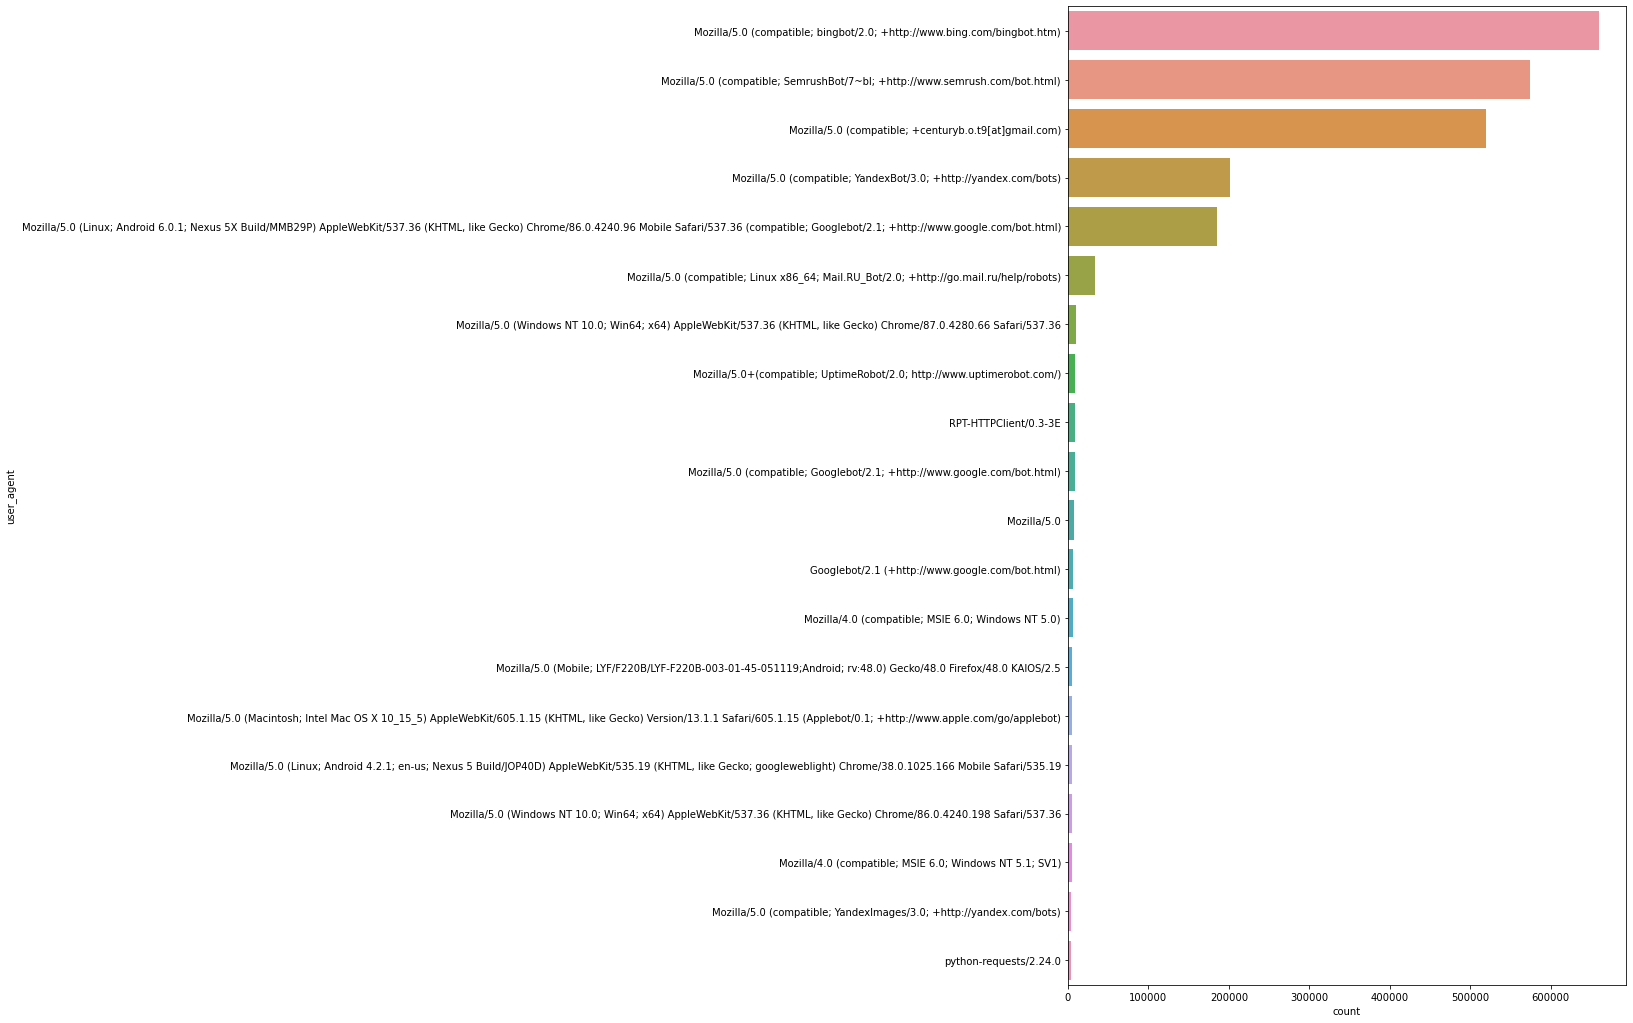

In [37]:
fig, ax = plt.subplots(figsize=(10,18))
barplot = sns.barplot(data=df_sum[:20], y='user_agent', x='count', orient='h', ax=ax)

In [59]:
sys.path.append('../src/')
from clf_parser import CLFParse

In [60]:
parser = CLFParse(log_files)

In [61]:
parser.parse_files()

TypeError: 'NoneType' object is not iterable

In [66]:
log_files